In [1]:
from bs4 import BeautifulSoup
import requests

import csv

import pandas as pd
import numpy as np

import datetime
import pytz

%matplotlib notebook
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()

In [2]:
endDate = datetime.datetime.utcnow()
startDate = datetime.datetime.utcnow() - datetime.timedelta(days = 60)
station = 56003

def getBuoyData(stationId, end, start):
    dataType = 0
    
    # Fill the URL with start and end dates
    url = 'https://www.ndbc.noaa.gov/station_page.php?' + \
            'station=' + str(stationId) + '&' + \
            'type=' + str(dataType) + '&' + \
            'startyear=' + str(start.year) + '&' + \
            'startmonth=' + str(start.month).zfill(2) + '&' + \
            'startday=' + str(start.day).zfill(2) + '&' + \
            'endyear=' + str(end.year) + '&' + \
            'endmonth=' + str(end.month).zfill(2) + '&' + \
            'endday=' + str(end.day).zfill(2) + '&' + \
            'submit=Submit'
    
    # Use urllib.requests to get the data
    req = requests.get(url)
    html_doc = req.text
    
    # Using BeautifulSoup to Scrape Data from NOAA National Data Buoy Center
    soup = BeautifulSoup(html_doc, 'html.parser')

    for element in soup.find_all('textarea'):
        data = element.text

    splitData = data.split('\n')

    # Save it in rawData.csv
    with open('rawData.csv', 'w') as file:
        for line in splitData[:-1]:
            # Check if it is a header
            if line[0] == '#':
                continue
            # Add a line to CSV
            else:
                file.write(line)
                file.write('\n')
    
    # Read the CSV as a dataFrame
    dataFrame = pd.read_csv('rawData.csv', header = None, delimiter = r'\s+')
    
    # Return the dataFrame
    return dataFrame

dataBuoy = getBuoyData(station, endDate, startDate)

In [3]:
def processDataframe(dataBuoy):
    # Date and time in UTC format
    year = dataBuoy[0]
    month = dataBuoy[1]
    day = dataBuoy[2]
    hour = dataBuoy[3]
    minute = dataBuoy[4]
    second = dataBuoy[5]

    # Data type and actual height
    dataType = dataBuoy[6]
    height = dataBuoy[7]

    # Change the individual date and time series to a single datetime list
    date_time = []
    for x in range(len(year)):
        date_time.append(datetime.datetime(year = year[x],
                                           month = month[x],
                                           day = day[x],
                                           hour = hour[x],
                                           minute = minute[x],
                                           second = second[x],
                                           tzinfo = pytz.utc))

    # Re-create the dataFrame
    zippedList = list(zip(date_time, height))
    dataBuoy = pd.DataFrame(zippedList, columns = ['datetime', 'height'])
    
    return dataBuoy

dataBuoy = processDataframe(dataBuoy)

Mean sea level is 5658.49 m


<IPython.core.display.Javascript object>


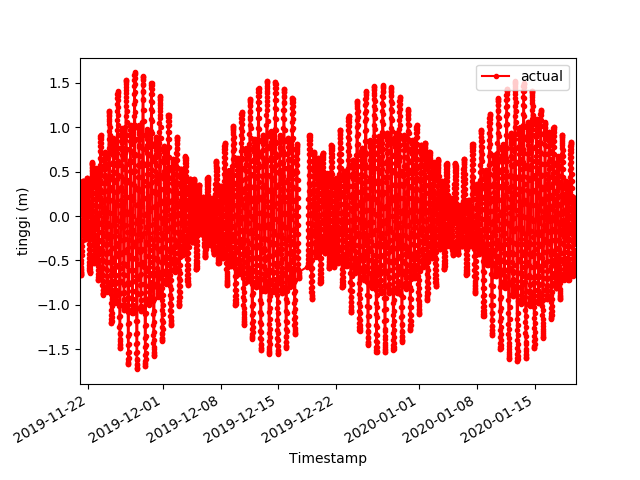

In [4]:
def plotFigure(x_act, y_act):    
    figure = plt.figure()
    axes1 = figure.add_subplot(111)
    axes1.set_ylabel('tinggi (m)')
    axes1.set_xlabel('Timestamp')
    axes1.plot(x_act, y_act, marker = '.', color = 'red', 
                  label = 'actual')
    axes1.legend(loc = 'upper right')
    axes1.set_xlim(x_act[-1], x_act[0])
    plt.gcf().autofmt_xdate()
    plt.show()

arrayDatetime = np.array(dataBuoy['datetime'].to_list())
arrayRawHeight = np.array(dataBuoy['height'].to_list())

averageData = np.average(arrayRawHeight)
print("Mean sea level is %.2f m" % averageData)

arrayHeight = np.subtract(arrayRawHeight, averageData)

plotFigure(arrayDatetime, arrayHeight)